## 1️⃣ ResNet
ViT 실습에 앞서 성능을 비교하기 위한 CNN-based model로 ResNet 실습을 갖고 왔습니다! 코드 설명도 달아놓았는데 공부하실 때 도움되었음 좋겠네요,,
실습하실 때 사본 만들어서 편집하시면 될 것 같습니다~!

In [4]:
import numpy as np                                                       # 데이터 전처리, 배열 연산, 통계 계산 등에 사용
import torch                                                             # Tensor 연산, GPU 사용, 자동 미분 등을 담당
import torch.nn as nn                                                    # Conv2d, Linear, ReLU 같은 모델 구성 요소 정의 시 사용
import torch.nn.functional as F                                          # activation, loss function 등을 함수 형태로 제공
import matplotlib.pyplot as plt                                          # 그래프 및 이미지 시각화를 위해 사용
import seaborn as sns                                                    # matplotlib 기반의 고급 시각화 라이브러리
from torchvision import datasets, transforms                             # MNIST, CIFAR 같은 표준 이미지 데이터셋 제공 & 이미지 resize, normalize, tensor 변환 등 전처리 파이프라인 구성
from sklearn.metrics import confusion_matrix, classification_report      # 혼동행렬과 같이 모델 성능을 정량적으로 평가할 때 사용

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# hyperparameter
batch_size = 32
num_epoch = 5                                                            # 시간 관계상 5회로 설정 (나중에 혼자 실습할 때는 10 이상으로 설정해주세요~)

In [5]:
train_dataset = datasets.CIFAR10(root="../data/CIFAR10",
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.RandomHorizontalFlip(),    # 증강은 하나만 했습니다 (잘 모르는 분들은 data augmentation 검색!!)
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
test_dataset = datasets.CIFAR10(root="../data/CIFAR10",
                              train=False,
                               transform=transforms.Compose([            # 테스트용 데이터는 증강할 필요가 없겠죠?
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)                 # shuffle의 의미는 2주차 세션 실습때 다뤘습니다! 기억 안나면 복습!
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [6]:
# DataLoader가 제대로 동작했는지 확인
for (X_train, y_train) in train_loader:
    print(f"X_train: {X_train.size()}, type: {X_train.type()}")
    print(f"y_train: {y_train.size()}, type: {y_train.type()}")
    break

X_train: torch.Size([32, 3, 32, 32]), type: torch.FloatTensor
y_train: torch.Size([32]), type: torch.LongTensor


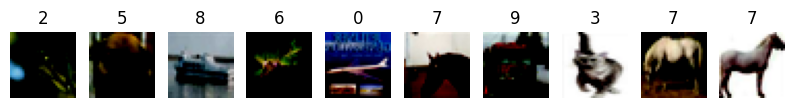

In [7]:
# 그냥 데이터 체크해보기 (색이 바랜 건 정규화 때문!)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title(str(y_train[i].item()))

In [8]:
# Residual Block (skip connection 만들기)
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()

        # 첫 번째 3x3 convolution
        self.conv1 = nn.Conv2d(in_planes, planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 3x3 convolution
        self.conv2 = nn.Conv2d(planes, planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        # Skip connection
        self.shortcut = nn.Sequential()

        # 입력과 출력 차원이 다를 경우 1x1 convolution으로 맞춤
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        # Conv → BN → ReLU
        out = F.relu(self.bn1(self.conv1(x)))
        # Conv → BN
        out = self.bn2(self.conv2(out))
        # skip connection
        out += self.shortcut(x)
        # 최종 ReLU
        out = F.relu(out)
        return out

In [9]:
# 전체 ResNet 모델 구조 정의
class ResNet(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10):
        super(ResNet, self).__init__()

        # 현재 feature channel 수
        self.in_planes = 16

        # 입력 이미지(3채널 RGB)를 16채널 feature map으로 변환
        self.conv1 = nn.Conv2d(3, 16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(16)

        # Residual block들을 단계별로 쌓음
        # 뒤로 갈수록 channel 증가 + spatial size 감소
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)

        # 과적합 방지를 위한 dropout
        self.dropout = nn.Dropout(p=0.5)

        # 최종 fully connected layer
        self.linear = nn.Linear(128, num_classes)

    # Residual block 여러 개를 하나의 layer로 만드는 함수
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        # 초기 convolution
        out = F.relu(self.bn1(self.conv1(x)))
        # Residual layers 통과
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global Average Pooling
        out = F.adaptive_avg_pool2d(out, (1,1))
        # Flatten
        out = out.view(out.size(0), -1)
        # 최종
        out = self.linear(out)
        return out

In [10]:
# set model, optimizer, loss fn
model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# 모델 구조 확인
display(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [11]:
# 모델 평가 (Validation / Test)
def evaluate(model, data_loader, criterion, device):
    model.eval()      # evaluation 모드 (dropout, batchnorm 비활성화)
    total_loss = 0
    correct = 0
    total = 0

    # gradient 계산 비활성화 : 메모리 절약 + 속도 향상
    with torch.no_grad():
        for image, label in data_loader:
            image, label = image.to(device), label.to(device)

            # forward pass
            output = model(image)

            # batch loss 누적
            total_loss += criterion(output, label).item() * image.size(0)

            # 가장 큰 logit을 예측 클래스로 선택
            prediction = output.argmax(dim=1)

            # accuracy 계산
            correct += prediction.eq(label).sum().item()
            total += label.size(0)

    avg_loss = total_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# 학습 진행 상황 출력용 progress bar (25기대표는 progress bar or 타이머 없이는 못삽니다..)
def print_progress_bar(iteration, total, length=30):
    filled = int(length * iteration // total)
    bar = '█' * filled + '-' * (length - filled)
    print(f"\rProgress: |{bar}| {iteration}/{total} batches", end='')

def train(model, train_loader, optimizer, criterion, device):
    model.train()      # training 모드 (dropout, batchnorm 활성화)
    running_loss = 0
    correct = 0
    total = 0
    total_batches = len(train_loader)

    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # gradient 초기화
        optimizer.zero_grad()

        # forward
        output = model(image)

        # loss 계산
        loss = criterion(output, label)

        # backward (gradient 계산)
        loss.backward()

        # parameter 업데이트
        optimizer.step()

        # loss 및 accuracy 누적
        running_loss += loss.item() * image.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)

        # 진행 상황 출력
        print_progress_bar(batch_idx + 1, total_batches)

    print()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [12]:
# Early stopping을 위한 변수 초기화 (현재 epoch = 5 라서 의미는 전혀 없지만 나중에 높은 숫자로 설정했을 때 좋습니다!)
best_val_loss = float('inf')      # 현재까지의 가장 낮은 validation loss (초기값은 무한대)
patience = 5                      # val_loss가 개선되지 않아도 기다려줄 epoch 수
patience_counter = 0              # 개선 안 된 epoch가 몇 번 연속인지 카운트

# # epoch별 loss/accuracy 기록용 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 학습 루프 (epoch 반복)
for epoch in range(1, num_epoch + 1):

    # 1) 한 epoch 학습
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)

    # 2) 평가
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    # 3) 기록 저장 (그래프 그릴 때 사용)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 4) 진행 상황 출력
    print(f"\n[Epoch {epoch}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f}, Val Accuracy:   {val_acc:.2f}%\n")

    # Early stopping : val_loss가 더 이상 좋아지지 않으면 학습 중단 (과적합 방지용인데, 현재는 무의미!)
    if val_loss < best_val_loss:
        # 성능이 개선되면 best 기록 갱신 + 현재 모델 저장
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        # 성능이 개선되지 않으면 카운터 증가
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 1]
Train Loss: 1.3014, Train Accuracy: 52.63%
Val Loss:   1.0659, Val Accuracy:   62.10%

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 2]
Train Loss: 0.8796, Train Accuracy: 68.96%
Val Loss:   0.8398, Val Accuracy:   70.45%

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 3]
Train Loss: 0.7076, Train Accuracy: 75.43%
Val Loss:   0.6923, Val Accuracy:   75.42%

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 4]
Train Loss: 0.6013, Train Accuracy: 79.00%
Val Loss:   0.6053, Val Accuracy:   78.69%

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 5]
Train Loss: 0.5281, Train Accuracy: 81.65%
Val Loss:   0.5836, Val Accuracy:   80.19%



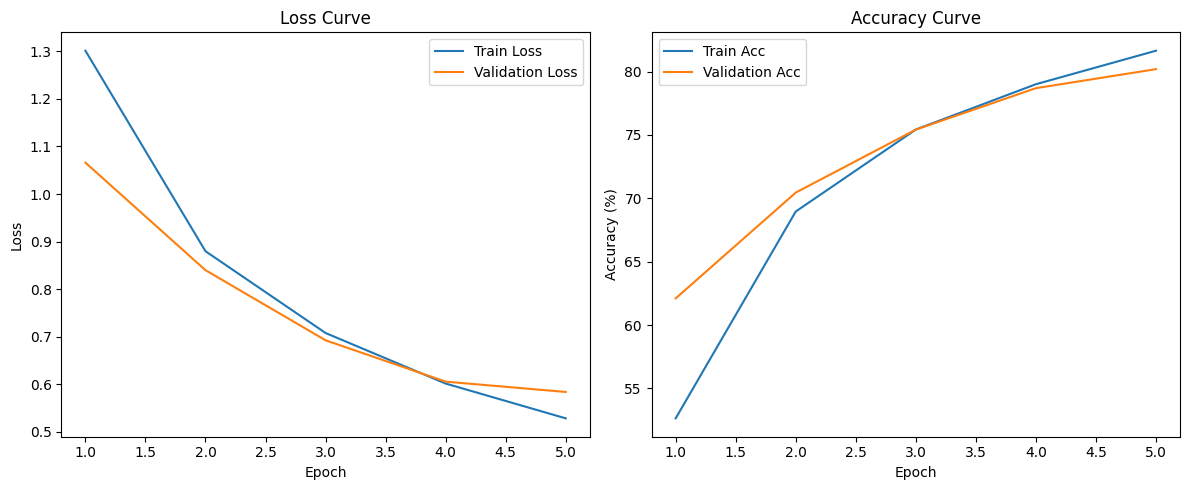

In [13]:
# loss, acc curve (다음에 기회가 된다면 Wandb라는 것도 알려드릴게요!)
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

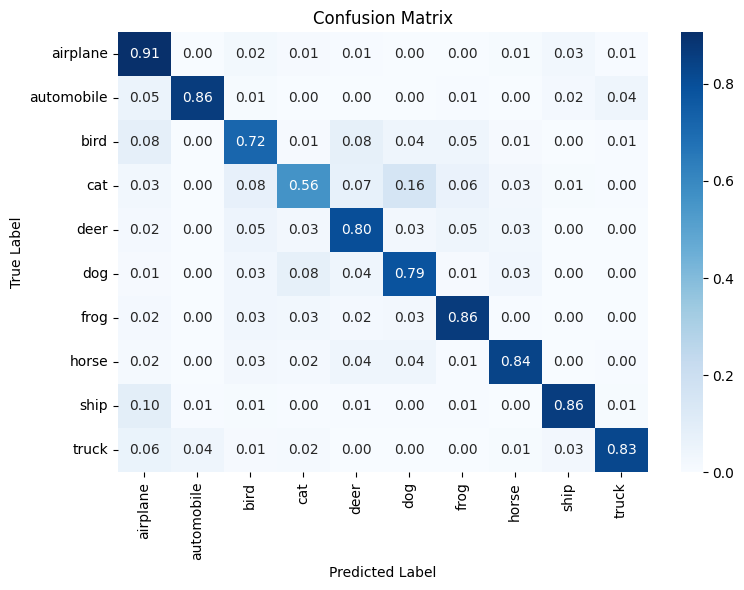

Classification Report:
               precision    recall  f1-score   support

    airplane       0.70      0.91      0.79      1000
  automobile       0.94      0.86      0.90      1000
        bird       0.72      0.72      0.72      1000
         cat       0.73      0.56      0.64      1000
        deer       0.75      0.80      0.77      1000
         dog       0.72      0.79      0.75      1000
        frog       0.82      0.86      0.84      1000
       horse       0.86      0.84      0.85      1000
        ship       0.90      0.86      0.88      1000
       truck       0.92      0.83      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



In [14]:
# confusion matrix

# 1) 클래스 이름
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 2) 예측 결과 수집
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3) confusion matrix 시각화
cm = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 4) classification report 출력
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

# cat vs dog가 눈에 띄네요 :) epoch을 늘리면 성능이 좋아질 거예요

## 2️⃣Vision Transformer
메인 주제인 ViT를 다뤄보겠습니다. epoch을 높게 수정하여 직접 ResNet과 성능 비교하면 재미있을 것 같아요!

In [21]:
import timm                      # ResNet, ViT, EfficientNet 등 다양한 최신 pretrained 모델을 쉽게 불러올 수 있음

# ResNet도 불러올 수 있습니다! (ResNet은 shortcut 구조를 직접 보는게 좋을 것 같아서 설계해봤습니다 ㅎㅎ!)
model = timm.create_model(
    "vit_tiny_patch16_224",      # 사용할 ViT 모델 구조 (실습 시간 줄이기 위해 tiny 버전, patch size 16, 기본 입력 224)
    pretrained=False,             # 사전학습된 가중치 사용 여부 (ViT를 직접 설계하지 않고 timm을 통해 불러오는 이유!)
    img_size=32,                 # 입력 이미지 크기 (CIFAR-10: 32x32이기 때문. Resize augmentation을 하셔도 됩니다!)
    patch_size=4,                # 이미지를 4x4 patch로 분할
    num_classes=10               # 최종 분류 클래스 수 (CIFAR-10)
)
model = model.to(device)         # 모델을 GPU 또는 CPU로 이동

In [22]:
num_epoch = 3                       # epoch = 3 으로 줄여볼게요..! (나중에 혼자 실습할 때는 10 이상으로 설정해주세요~)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(      # AdamW optimizer 사용 (Vision Transformer에 자주 사용됨)
    model.parameters(),             # 학습할 모든 파라미터
    lr=3e-4,                        # 3e-4 = 0.0003
    weight_decay=0.05               # weight decay (L2 regularization) → 과적합 방지
)

In [23]:
# 위 코드 복붙
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(1, num_epoch + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\n[Epoch {epoch}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f}, Val Accuracy:   {val_acc:.2f}%\n")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 1]
Train Loss: 1.8187, Train Accuracy: 31.42%
Val Loss:   1.6091, Val Accuracy:   40.77%

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 2]
Train Loss: 1.5454, Train Accuracy: 42.89%
Val Loss:   1.4703, Val Accuracy:   46.09%

Progress: |██████████████████████████████| 1563/1563 batches

[Epoch 3]
Train Loss: 1.3885, Train Accuracy: 48.87%
Val Loss:   1.3906, Val Accuracy:   49.56%



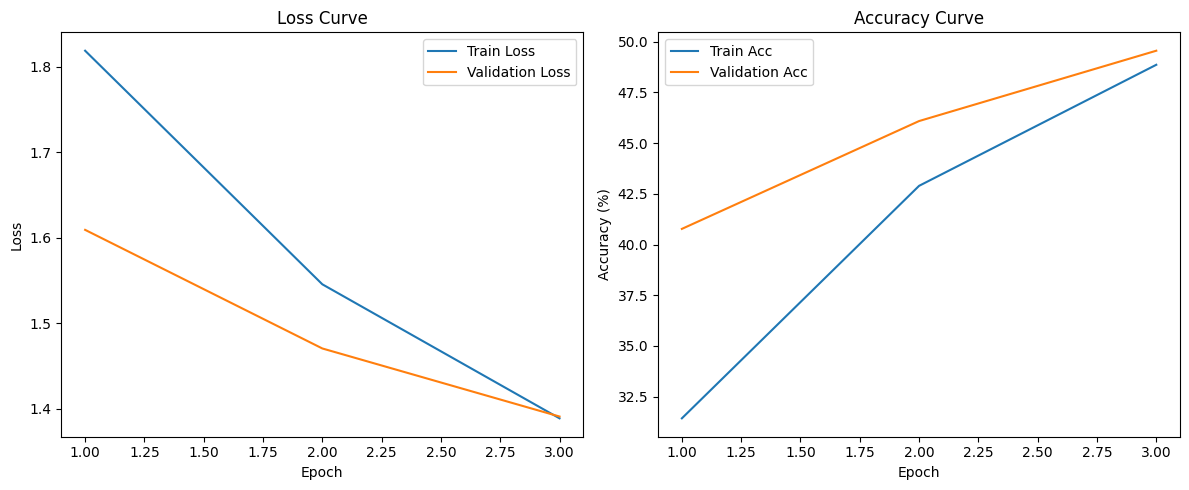

In [24]:
# 위 코드 복붙 2
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

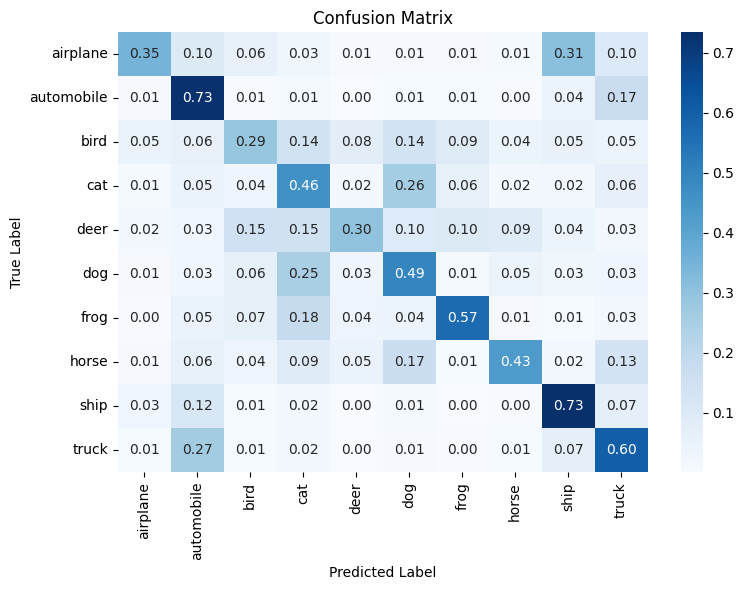

Classification Report:
               precision    recall  f1-score   support

    airplane       0.69      0.35      0.46      1000
  automobile       0.49      0.73      0.59      1000
        bird       0.40      0.29      0.34      1000
         cat       0.34      0.46      0.39      1000
        deer       0.56      0.30      0.39      1000
         dog       0.40      0.49      0.44      1000
        frog       0.65      0.57      0.61      1000
       horse       0.65      0.43      0.52      1000
        ship       0.55      0.73      0.63      1000
       truck       0.47      0.60      0.53      1000

    accuracy                           0.50     10000
   macro avg       0.52      0.50      0.49     10000
weighted avg       0.52      0.50      0.49     10000



In [25]:
# 위 코드 복붙 3
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

##※ 과제 안내 ※
1. 이번 세션에서 다룬 Vision Transformer는 최근 이미지 분류 분야에서 ResNet을 뛰어넘는 성능을 보이며 SOTA(State-of-the-Art) 모델로 자리 잡았음을 배웠습니다. 그럼에도 불구하고 ResNet은 여전히 다양한 비전 응용 분야에서 널리 활용되고 있는데요! ViT와 비교했을 때 ResNet이 갖는 장점 한 가지 이상을 GitHub 과제 제출 시 **Pull Request 내용란에 작성**해주세요~ (ChatGPT로 정답을 적어도 좋지만.. 일차원적인 본인 생각이라도 적어주셨으면 좋겠습니다! 😋😋)
: ResNet은 CNN 기반으로 동일한 필터를 이미지 전체에 반복적으로 적용할 수 있는 inductive bias를 가지고 있다. 이에 특정 패턴을 효율적으로 학습할 수 있어 데이터 셋이 적은 경우에도 비교적 잘 학습될 수 있다는 장점이 있다.반면 ViT는 Transformer기반 모델이기에 Self-Attention을 통해 학습하며 inductive bias가 구조적으로 이루어지지 않는다. 따라서 ViT는 데이터 셋이 충분한 경우에 더 좋은 성능을 보이는 경향이 있다.

---


2. 위 코드에서 pretrained = True ViT 모델을 불러왔는데요! False로 설정한다면 어떤 결과가 나올지 직접 코드를 돌리면서 확인해보면 좋을 것 같아요~ 어떤 차이가 있을지 직접 결과를 확인한 후 성능이 그렇게 나온 이유를 위와 마찬가지로 **Pull Request 내용란에 작성**해주세요~ (Hint: 초대형 어쩌구.. 🧐🧐)
: pretrained = True인 경우 accuracy가 0.9, F1-score가 0.9로 나온 반면에 pretrained = False인 경우 accuracy가 0.5, F1-score가 0.49까지 성능이 떨어졌다. 이는 사전 학습된 모델이 대규모 데이터 셋으로 사전 학습이 되었기 때문에 더 좋은 성능이 나올 수 밖에 없는 것 같다.

---

3. (선택) 이로써 자연어처리(NLP)와 컴퓨터비전(CV)의 기초&심화 세션을 마쳤습니다! 지금까지 어렵거나 아쉬웠던 내용 등 26기 BASE 커리큘럼 평가를 **위 과제와 함께 PR로** 편하게 남겨주시면 감사하겠습니다. (다음 기수 내용 수정 / 난이도 조절을 위해.. 딱히 없으면 안 적어도 됨 👍👍)

### 마치며

다음 주 세션은 잠시 정규 트랙을 벗어나 **자유 주제**로 진행됩니다.
25기 부원분들께서 유익한 주제를 준비해주셨다고 하니 꼭 오셔서 재미있게 함께해 주세요 🙂🙂

---

그리고 다다음 주, 7주차 세션에서는 **미니프로젝트 1 최종 발표**가 예정되어 있습니다.
그동안 준비하신 결과를 공유하는 자리인 만큼, 여러분들의 발표를 기대하겠습니다! 😊😊